In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
# upload data
orders = pd.read_csv('../data/raw/orders.csv')
products = pd.read_csv('../data/raw/products.csv')
order_products_prior = pd.read_csv('../data/raw/order_products__prior.csv')
order_products_train = pd.read_csv('../data/raw/order_products__train.csv')
aisles = pd.read_csv('../data/raw/aisles.csv')
departments = pd.read_csv('../data/raw/departments.csv')

In [18]:
import sys

sys.path.append('../src/')

import importlib

import vizualizations

importlib.reload(vizualizations)

from vizualizations import  (
    plot_distribution_of_orders,
    plot_order_hours, 
    plot_orders_by_dow, 
    plot_aisles_per_department, 
    plot_sales_by_department_barplot, 
    plot_sales_by_department_boxplot, 
    plot_sales_by_aisle_barplot, 
    plot_sales_by_aisle_boxplot, 
    plot_top_20_products_barplot, 
    scatterplot_top_100_products
)


In [19]:
print(f"DATASET OVERVIEW")
print(f"  - Orders: {len(orders):,}")
print(f"  - Products: {len(products):,}")
print(f"  - Users: {orders['user_id'].nunique():,}")
print(f"  - Departments: {len(departments)}")
print(f"  - Aisles: {len(aisles)}")

DATASET OVERVIEW
  - Orders: 3,421,083
  - Products: 49,688
  - Users: 206,209
  - Departments: 21
  - Aisles: 134


## Analyze of the products, aisles and departments datasets

In [20]:
# compute product sales with information from products, aisles and departments

product_sales = order_products_prior.groupby('product_id').agg(nb_sales=('order_id', 'count'),reorder_rate=('reordered', 'mean')).reset_index()
    
products_enriched = product_sales.merge(products[['product_id', 'product_name', 'aisle_id', 'department_id']], on='product_id',how='left')

products_enriched = products_enriched.merge(departments[['department_id', 'department']], on='department_id',how='left')
    
products_enriched = products_enriched.merge(aisles[['aisle_id', 'aisle']], on='aisle_id',how='left')

# add frequency of purchase
total_orders = order_products_prior['order_id'].nunique()
    
products_enriched['purchase_frequency'] = (products_enriched['nb_sales'] / total_orders * 100)

products_enriched.head(15)


product_id  nb_sales  reorder_rate  \
0            1      1852      0.613391   
1            2        90      0.133333   
2            3       277      0.732852   
3            4       329      0.446809   
4            5        15      0.600000   
5            6         8      0.375000   
6            7        30      0.400000   
7            8       165      0.503030   
8            9       156      0.525641   
9           10      2572      0.506998   
10          11       104      0.567308   
11          12       246      0.512195   
12          13         9      0.333333   
13          14        17      0.117647   
14          15         4      0.250000   

                                         product_name  aisle_id  \
0                          Chocolate Sandwich Cookies        61   
1                                    All-Seasons Salt       104   
2                Robust Golden Unsweetened Oolong Tea        94   
3   Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4                           Green Chile Anytime Sauce         5   
5                                        Dry Nose Oil        11   
6                      Pure Coconut Water With Orange        98   
7                   Cut Russet Potatoes Steam N' Mash       116   
8                   Light Strawberry Blueberry Yogurt       120   
9      Sparkling Orange Juice & Prickly Pear Beverage       115   
10                                  Peach Mango Juice        31   
11                         Chocolate Fudge Layer Cake       119   
12                                  Saline Nasal Mist        11   
13                     Fresh Scent Dishwasher Cleaner        74   
14                           Overnight Diapers Size 6        56   

    department_id     department                          aisle  \
0              19         snacks                  cookies cakes   
1              13         pantry              spices seasonings   
2               7      beverages                            tea   
3               1         frozen                   frozen meals   
4              13         pantry     marinades meat preparation   
5              11  personal care               cold flu allergy   
6               7      beverages                  juice nectars   
7               1         frozen                 frozen produce   
8              16     dairy eggs                         yogurt   
9               7      beverages  water seltzer sparkling water   
10              7      beverages                   refrigerated   
11              1         frozen                 frozen dessert   
12             11  personal care               cold flu allergy   
13             17      household                dish detergents   
14             18         babies                  diapers wipes   

    purchase_frequency  
0             0.057607  
1             0.002799  
2             0.008616  
3             0.010234  
4             0.000467  
5             0.000249  
6             0.000933  
7             0.005132  
8             0.004852  
9             0.080003  
10            0.003235  
11            0.007652  
12            0.000280  
13            0.000529  
14            0.000124

In [21]:
products_enriched.isna().sum()

product_id            0
nb_sales              0
reorder_rate          0
product_name          0
aisle_id              0
department_id         0
department            0
aisle                 0
purchase_frequency    0
dtype: int64

In [22]:
products_enriched.value_counts()

product_id  nb_sales  reorder_rate  product_name                                                       aisle_id  department_id  department     aisle                       purchase_frequency
1           1852      0.613391      Chocolate Sandwich Cookies                                         61        19             snacks         cookies cakes               0.057607              1
2           90        0.133333      All-Seasons Salt                                                   104       13             pantry         spices seasonings           0.002799              1
3           277       0.732852      Robust Golden Unsweetened Oolong Tea                               94        7              beverages      tea                         0.008616              1
4           329       0.446809      Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce  38        1              frozen         frozen meals                0.010234              1
5           15        0.600000

We have 49 677 lines in products_enriched versus 49688 in products meaning that 11 products have never been purchased. We can assume that if they haven't been purchased we are not going to recommend those products.

In [23]:
print("PRODUCT CATALOG OVERVIEW")

## Nber of products, aisles, departments
print(f"\nCatalog Statistics:")
print(f"  - Total products (with sales): {len(products_enriched):,}")
print(f"  - Total aisles: {products_enriched['aisle_id'].nunique()}")
print(f"  - Total departments: {products_enriched['department_id'].nunique()}")

## List of departments
print(f"\n Departments:")
for dept in sorted(products_enriched['department'].unique()):
    print(f"  - {dept}")

## Top 10 aisles by product count
print(f"\n Top 10 Aisles by product count:")
top_aisles_by_product = products_enriched['aisle'].value_counts().head(10)
for aisle, count in top_aisles_by_product.items():
    print(f"  - {aisle}: {count} products")

PRODUCT CATALOG OVERVIEW

Catalog Statistics:
  - Total products (with sales): 49,677
  - Total aisles: 134
  - Total departments: 21

 Departments:
  - alcohol
  - babies
  - bakery
  - beverages
  - breakfast
  - bulk
  - canned goods
  - dairy eggs
  - deli
  - dry goods pasta
  - frozen
  - household
  - international
  - meat seafood
  - missing
  - other
  - pantry
  - personal care
  - pets
  - produce
  - snacks

 Top 10 Aisles by product count:
  - missing: 1255 products
  - candy chocolate: 1246 products
  - ice cream ice: 1091 products
  - vitamins supplements: 1038 products
  - yogurt: 1026 products
  - chips pretzels: 989 products
  - tea: 894 products
  - packaged cheese: 890 products
  - frozen meals: 880 products
  - cookies cakes: 873 products


In [24]:
products_enriched.groupby('department')['product_id'].nunique().describe()

count      21.000000
mean     2365.571429
std      1914.136635
min        38.000000
25%      1081.000000
50%      1516.000000
75%      3448.000000
max      6563.000000
Name: product_id, dtype: float64

In [25]:
products_enriched.groupby('aisle')['product_id'].nunique().describe()

count     134.000000
mean      370.723881
std       266.887924
min        12.000000
25%       179.500000
50%       305.500000
75%       497.250000
max      1255.000000
Name: product_id, dtype: float64

There are 49 677 products in scope

The products are organised into 21 departments and 134 aisles.

We also see that an aisle contains between 12 and 1255 products with anverage of 371. Concerning the departments they contain between 38 and 6563 products with an average of 2365.

We also see there is a department called 'missing' and the top 1 aisle in term of number products is also called 'missing'. We can assume it is for products that are not categorized. Let's check if the department 'missing' contains only the aisle 'missing'. Let's do the same for the category 'other'.



In [26]:
# Special categories : 'missing' vs 'other'


special_categories = ['missing', 'other']
total_sales = products_enriched['nb_sales'].sum()

for cat in special_categories:
    spe_cat= products_enriched[products_enriched['department'] == cat]

    print(f"\n Department: '{cat}'")
    print(f"  Products: {len(spe_cat):,} ({len(spe_cat)/len(products_enriched)*100:.2f}% of catalog)")
    print(f"  Total sales: {spe_cat['nb_sales'].sum():,} ({spe_cat['nb_sales'].sum()/total_sales*100:.2f}% of sales)")
    print(f"  Unique aisles: {spe_cat['aisle'].nunique()}")
    
    if spe_cat['aisle'].nunique() == 1:
        print(f"  Aisles: {list(spe_cat['aisle'].unique())}")
    else:
        print(f"  Aisles: Multiple aisles present")

    print(f"\n  Top 5 products:")
    top_5_names = spe_cat.nlargest(5, 'nb_sales')['product_name'].tolist()
    for name in top_5_names:
        print(f"    - {name}")




 Department: 'missing'
  Products: 1,255 (2.53% of catalog)
  Total sales: 69,145 (0.21% of sales)
  Unique aisles: 1
  Aisles: ['missing']

  Top 5 products:
    - Organic Riced Cauliflower
    - Peanut Butter Ice Cream Cup
    - Organic Mango Yogurt
    - Organic Celery Bunch
    - Natural Lemon Flavored Sparkling Water

 Department: 'other'
  Products: 548 (1.10% of catalog)
  Total sales: 36,291 (0.11% of sales)
  Unique aisles: 1
  Aisles: ['other']

  Top 5 products:
    - Roasted Almond Butter
    - Light CocoWhip! Coconut Whipped Topping
    - 93/7 Ground Beef
    - Coconut Almond Granola
    - Coffee Mate French Vanilla Creamer Packets


This confirms the hypothesis, the departments 'missing' and 'other' contains only 1 aisle with the same name. When we look at the top 5 products of each category it seems they don't have any link. 
Those products represent less than 1% of the sales so we're not going to dig more into it. We'll see after if we keep them or if they will be problematic for creating models and recommendations bundles because of the 'non-sense' of this category.

In [27]:
aisles_per_department = products_enriched.groupby('department')['aisle'].nunique().reset_index(name='nb_aisles').sort_values('nb_aisles', ascending=False)

# Visualisation
fig = plot_aisles_per_department(aisles_per_department)
fig

We see that all departments contain in between 1 and 17 aisles. The department 'personal care' is the one with the higher count of aisles this mean there is a lot of diversity inside this department.

In [28]:
# analyse sales per department

sales_dept = products_enriched.groupby('department').agg(nb_products=('product_id', 'count'),total_sales=('nb_sales', 'sum')).reset_index().sort_values('total_sales', ascending=False)

fig = plot_sales_by_department_barplot(sales_dept)
fig

In [29]:
total_sales= products_enriched['nb_sales'].sum()

sales_dept['Percentage of sales']= (sales_dept['total_sales'] / total_sales * 100).round(2)

sales_dept.head(10)

department  nb_products  total_sales  Percentage of sales
19          produce         1684      9479291                29.23
7        dairy eggs         3448      5414016                16.69
20           snacks         6263      2887550                 8.90
3         beverages         4363      2690129                 8.29
10           frozen         4007      2236432                 6.90
16           pantry         5370      1875577                 5.78
2            bakery         1516      1176787                 3.63
6      canned goods         2092      1068058                 3.29
8              deli         1322      1051249                 3.24
9   dry goods pasta         1858       866627                 2.67

The department 'produce' (fruits and vegetables) represent the highest number of sales (29% of the total) 

The second one is 'dairy eggs' (milk, cheese, ...) with more than 16%. 

We also see that the deppartments with the highest number of sales are not the ones with the higher number of products.

In [30]:
# Let's visualize the distribution of product sales per department
fig=plot_sales_by_department_boxplot(products_enriched)
fig

We can see there are a high variability of sales inside each department with a lot of outliers. This means that some products have a big impact on sales and it's probably on them that we'll focus.

In [31]:
top_aisles_sales = products_enriched.groupby('aisle').agg(nb_products=('product_id', 'count'),total_sales=('nb_sales', 'sum')).reset_index().sort_values('total_sales', ascending=False).head(20)

top_aisles_sales.head(20)

aisle  nb_products  total_sales
50                    fresh fruits          382      3642188
53                fresh vegetables          569      3418021
98      packaged vegetables fruits          615      1765313
133                         yogurt         1026      1452343
93                 packaged cheese          890       979763
83                            milk          243       891015
131  water seltzer sparkling water          344       841533
25                  chips pretzels          989       722470
119                soy lactosefree          293       638253
11                           bread          557       584834
110                   refrigerated          673       575881
62                  frozen produce          361       522654
71                   ice cream ice         1091       498425
32                        crackers          747       458838
42             energy granola bars          832       456386
41                            eggs          125       452134
80                      lunch meat          373       395130
59                    frozen meals          880       390299
4                baby food formula          718       382456
51                     fresh herbs           86       377741

In [32]:
fig=plot_sales_by_aisle_barplot(top_aisles_sales)
fig

'Fresh fruits' and 'fresh vegetables' are the 2 main aisles in term of number of sales. And then we also find the aisles of 'dairy eggs'

In [33]:
top_aisles = products_enriched.groupby('aisle')['nb_sales'].sum().nlargest(20).index
sales_by_aisle = products_enriched[products_enriched['aisle'].isin(top_aisles)]

In [34]:
fig=plot_sales_by_aisle_boxplot(sales_by_aisle)
fig

We also find a high variability of sales within aisles. For example, the top sales of "fresh fruits" are much higher than the sales of "fresh vegetables".

Let's check the importance of those 20 aisles on the total sales :

In [35]:
total_sales = products_enriched['nb_sales'].sum()
total_products = len(products_enriched)

top_20_sales = top_aisles_sales['total_sales'].sum()
top_20_products = top_aisles_sales['nb_products'].sum()

percentage_sales = (top_20_sales / total_sales) * 100
percentage_products = (top_20_products / total_products) * 100

print(f"  - {top_20_products:,} products ({percentage_products:.1f}% of catalog)")
print(f"  - {top_20_sales:,} sales ({percentage_sales:.1f}% of total)")


  - 11,794 products (23.7% of catalog)
  - 19,445,677 sales (60.0% of total)


As we can see those 20 aisles represent 60% of the total sales. But we need to pay attention that we only focus here on the quantity of sales and not the value of sales. We can assume that some products such as 'meat' or 'personal care' are more expensive and can have a big impact on the results of the company.

### Focus on products

In [36]:
top_20_products = products_enriched.nlargest(20, 'nb_sales')

fig=plot_top_20_products_barplot(top_20_products)
fig

The top 20 products in term of sales are represented by 19 products from 'Produce' department and 1 from 'Dairy eggs'. The top products in vegetables and fruits are from far the highest numbers of sales in Instacart !

It would be interesting to check quickly the relation in between high sales and reorder rate.

In [37]:
#Let's have a look at the reorder rate vs number of sales for the top 100 products

top_100_products = products_enriched.nlargest(100, 'nb_sales')

fig=scatterplot_top_100_products(top_100_products)
fig

We can see for example for bananas that they have also a high reorder rate. When we are looking at the other products we see that a high number of sales is not always linked to a high reorder rate. 

The key takeaways of the analysis of product sales are :

Hierarchy : 21 departments -> 134 aisles -> 49677 products

Dominant categories : 

    - Departments : Produce (29%), Dairy eggs (17%), Snacks (9%)

    - Aisles : Fresh fruits and vegetables, packaged vegetables and yogurt

    - Products : Bananas, organic bananas and organic strawberries are the best sellers

Strategic insights and limitation :

    - We saw that the top 20 aisles represent 60% of the total sales

    - We need to pay attention that we only focus on the frequency of sales. We don't have the quantity of each products in one order

    - It would be interesting to add prices to not simply compare the frequency of sales but also the values


## Analyze of the number of orders and clients

In [38]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [39]:
print(f'number of rows:', orders.shape[0])

number of rows: 3421083


In [40]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Around 200k lines on 3.4M  with missing values on 'days_since_prior_order' => assuming it means it's the first order of the user ?

In [41]:
user_order_counts = orders.user_id.value_counts().reset_index()
user_order_counts.columns = ['user_id', 'nb_orders']

user_order_counts['nb_orders'].describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: nb_orders, dtype: float64

We find again 206 209 different user_id so the hypothesis of value missing on 'days_since_prior_order' is correct.
We also see we have in between 4 and 100 commands per client in the database

In [42]:
fig=plot_distribution_of_orders(user_order_counts)
fig 

The average is way higher than then median. We have a right skewed distribution.
50% of the clients made less than 10 orders and 25% of clients made between 20 and 100 orders. 
It would be interesting to see the impact of the extreme values meaning important customers.

In [43]:
# Segments
occasional = user_order_counts[user_order_counts['nb_orders'] <= 10]
regular = user_order_counts[(user_order_counts['nb_orders'] > 10) & (user_order_counts['nb_orders'] <= 30)]
power = user_order_counts[user_order_counts['nb_orders'] > 30]

print(f"USER SEGMENTATION BASED ON ORDER FREQUENCY")
print(f"\n Casual customers (≤10 orders):")
print(f"   - Number : {len(occasional):,} users ({len(occasional)/len(user_order_counts)*100:.1f}%)")
print(f"   - Mean : {occasional['nb_orders'].mean():.1f} orders")

print(f"\n Regular custoemers (10-30 orders):")
print(f"   - Number : {len(regular):,} users ({len(regular)/len(user_order_counts)*100:.1f}%)")
print(f"   - Mean : {regular['nb_orders'].mean():.1f} orders")

print(f"\n Big customers (>30 orders):")
print(f"   - Number : {len(power):,} users ({len(power)/len(user_order_counts)*100:.1f}%)")
print(f"   - Mean : {power['nb_orders'].mean():.1f} orders")

# Impact on total orders
total_orders = user_order_counts['nb_orders'].sum()
power_orders = power['nb_orders'].sum()

print(f"\n IMPACT BUSINESS:")
print(f"   - Power users = {len(power)/len(user_order_counts)*100:.1f}% des users")
print(f"   - Génèrent {power_orders/total_orders*100:.1f}% des commandes")

USER SEGMENTATION BASED ON ORDER FREQUENCY

 Casual customers (≤10 orders):
   - Number : 104,513 users (50.7%)
   - Mean : 6.3 orders

 Regular custoemers (10-30 orders):
   - Number : 72,513 users (35.2%)
   - Mean : 17.7 orders

 Big customers (>30 orders):
   - Number : 29,183 users (14.2%)
   - Mean : 50.5 orders

 IMPACT BUSINESS:
   - Power users = 14.2% des users
   - Génèrent 43.1% des commandes


Let's have a look to the distribution of the orders by day. We'll use the US convention meaning that 0 is on Sunday.

In [44]:
# Let's have a look to the distribution of orders by day of the week
fig = plot_orders_by_dow(orders)
fig

As we can see, there are more orders made on Sunday and Monday and less in the middle of the week.

In [45]:
# Let's have a look to the distribution of orders by hour of the day
fig=plot_order_hours(orders)
fig

## Analyse of order_products dataset & bundles

In [46]:
order_products_prior.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [47]:
order_products_prior.reordered.value_counts()


reordered
1    19126536
0    13307953
Name: count, dtype: int64

In [48]:
#group by order_id to get the number of products in each order

basket_size=order_products_prior.groupby('order_id').size()
basket_size.name='basket_size'
basket_size.head()

order_id
2     9
3     8
4    13
5    26
6     3
Name: basket_size, dtype: int64

In [49]:
print(f"Statistics on basket sizes: ")
print(f"Average basket size: {basket_size.mean():.2f}")
print(f"Median basket size: ", basket_size.median())
print(f"Maximum basket size: ", basket_size.max())
print(f"Minimum basket size: ", basket_size.min())


Statistics on basket sizes: 
Average basket size: 10.09
Median basket size:  8.0
Maximum basket size:  145
Minimum basket size:  1


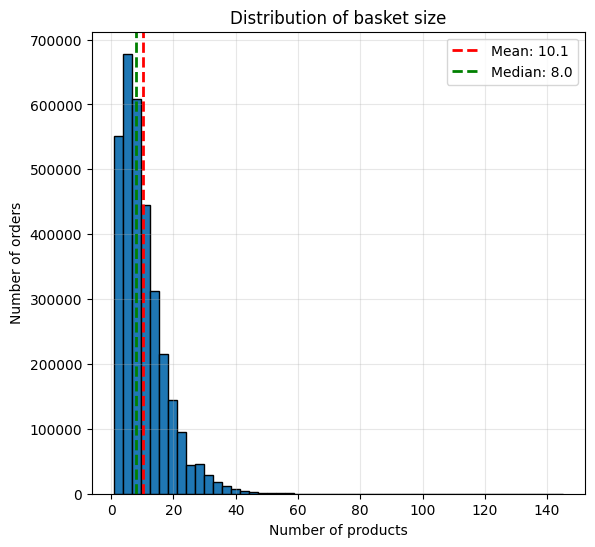

In [50]:
plt.figure(figsize=(14, 6))

# Subplot 1: Histogramme classique
plt.subplot(1, 2, 1)
plt.hist(basket_size, bins=50, edgecolor='black')
plt.xlabel('Number of products')
plt.ylabel('Number of orders')
plt.title('Distribution of basket size')
plt.axvline(basket_size.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {basket_size.mean():.1f}')
plt.axvline(basket_size.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {basket_size.median():.1f}')
plt.legend()
plt.grid(True, alpha=0.3)

We have a right-skewed distribution. The majority of the baskets are small. 

Let's check the products that are ordered the most frequently :

Number of orders per department :

In [51]:
dept_counts = order_products_prior.merge(products[['product_id', 'department_id']], on='product_id')['department_id'].value_counts()
dept_counts=dept_counts.reset_index()
dept_counts.columns = ['department_id', 'count']
dept_counts=dept_counts.merge(departments, on='department_id')
print(dept_counts)

    department_id    count       department
0               4  9479291          produce
1              16  5414016       dairy eggs
2              19  2887550           snacks
3               7  2690129        beverages
4               1  2236432           frozen
5              13  1875577           pantry
6               3  1176787           bakery
7              15  1068058     canned goods
8              20  1051249             deli
9               9   866627  dry goods pasta
10             17   738666        household
11             14   709569        breakfast
12             12   708931     meat seafood
13             11   447123    personal care
14             18   423802           babies
15              6   269253    international
16              5   153696          alcohol
17              8    97724             pets
18             21    69145          missing
19              2    36291            other
20             10    34573             bulk


Let's check the products that are the most often reordered :

Table with products as row ?
